<a href="https://colab.research.google.com/github/harshakalluri14/keylogger/blob/main/violencedetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Violence Detection using CNN + LSTM neural netowrk

## Imports

In [ ]:
# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Import necessary libraries
import cv2  # OpenCV library for computer vision tasks
import os   # Operating System library for interacting with the file system
import numpy as np  # NumPy for numerical operations
import keras  # Keras for high-level deep learning API
import matplotlib.pyplot as plt  # Matplotlib for data visualization
# import download  # (Commented out) Import download module (Note: Module is not used in the provided code)
from random import shuffle  # Shuffle function for randomizing data
from tensorflow.keras.applications import VGG16  # VGG16 model for image classification
from tensorflow.keras import backend as K  # Keras backend for low-level operations
from tensorflow.keras.models import Model, Sequential  # Model and Sequential for defining neural network architectures
from tensorflow.keras.layers import Input  # Input layer for model input
from tensorflow.keras.layers import LSTM  # LSTM layer for recurrent neural networks
from tensorflow.keras.layers import Dense, Activation  # Dense and Activation layers for neural network building
import sys  # System-specific parameters and functions
import h5py  # Interface for working with HDF5 files


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
keras.__version__

'2.15.0'

## Helper Functions

In [ ]:
def print_progress(count, max_count):
    # Calculate the percentage completion.
    pct_complete = count / max_count

    # Generate a status message. Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Write the message to the standard output (stdout) without a newline.
    sys.stdout.write(msg)

    # Flush the stdout buffer to ensure the message is displayed immediately.
    sys.stdout.flush()


In [ ]:
# Import the 'drive' module from the 'google.colab' package
from google.colab import drive

# Mount Google Drive to the '/content/drive' directory
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the input directory path where the data is located in Google Drive
in_dir = "/content/drive/MyDrive/data"

Copy some of the data-dimensions for convenience.

In [ ]:
# Set the frame size (assuming square frames)
img_size = 224

# Create a tuple representing the frame size (width, height)
img_size_touple = (img_size, img_size)

# Define the number of color channels (RGB)
num_channels = 3

# Calculate the total number of pixels in a flattened frame
img_size_flat = img_size * img_size * num_channels

# Specify the number of classes for classification (assuming Violence and No Violence)
num_classes = 2

# Define the number of files to be used for training
_num_files_train = 1

# Define the number of frames per video
_images_per_file = 20

# Calculate the total number of frames in the training set
_num_images_train = _num_files_train * _images_per_file

# Specify the video file extension
video_exts = ".avi"


In [ ]:
def get_frames(current_dir, file_name):

    in_file = os.path.join(current_dir, file_name)

    images = []

    vidcap = cv2.VideoCapture(in_file)

    success,image = vidcap.read()

    count = 0

    while count<_images_per_file:

        RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        res = cv2.resize(RGB_img, dsize=(img_size, img_size),
                                 interpolation=cv2.INTER_CUBIC)

        images.append(res)

        success,image = vidcap.read()

        count += 1

    resul = np.array(images)

    resul = (resul / 255.).astype(np.float16)

    return resul

### Helper function to get the names of the data downloaded and label it

In [ ]:
def label_video_names(in_dir):
    # List containing video names
    names = []

    # List containing video labels [1, 0] if it has violence and [0, 1] if not
    labels = []

    # Iterate through directories and files in the specified input directory
    for current_dir, dir_names, file_names in os.walk(in_dir):

        # Iterate through each file in the current directory
        for file_name in file_names:
            # Check if the file name starts with 'fi' indicating violence
            if file_name[0:2] == 'fi':
                labels.append([1, 0])  # Append [1, 0] for violence
                names.append(file_name)
            # Check if the file name starts with 'no' indicating no violence
            elif file_name[0:2] == 'no':
                labels.append([0, 1])  # Append [0, 1] for no violence
                names.append(file_name)

    # Combine names and labels into a list of tuples
    c = list(zip(names, labels))

    # Shuffle the data (names and labels)
    shuffle(c)

    # Unpack the shuffled data
    names, labels = zip(*c)

    # Return the shuffled names and labels
    return names, labels


### Plot a video frame to see if data is correct

In [ ]:
# Obtain the names and labels for the entire set of videos in the specified input directory
names, labels = label_video_names(in_dir)

Then we are going to load 20 frames of one video, for example

In [ ]:
names[12]

'no488_xvid.avi'

The video has violence, look at the name of the video, starts with 'fi'

In [ ]:
# Retrieve frames from the video specified by the 13th entry in 'names' list
frames = get_frames(in_dir, names[12])

Convert back the frames to uint8 pixel format to plot the frame

In [ ]:
# Convert the frames from normalized float values back to uint8 format (0-255 range)
visible_frame = (frames * 255).astype('uint8')

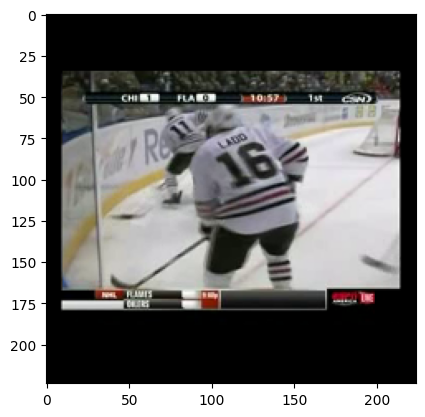

In [ ]:
# Display the 4th frame from the 'visible_frame' array using Matplotlib
plt.imshow(visible_frame[3])

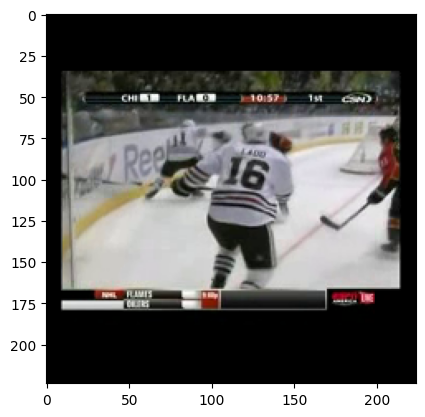

In [ ]:
# Display the 16th frame from the 'visible_frame' array using Matplotlib
plt.imshow(visible_frame[15])

## Pre-Trained Model: VGG16

In [ ]:
# Create an instance of the VGG16 model with pre-trained weights on ImageNet
image_model = VGG16(include_top=True, weights='imagenet')

Let's see the model summary

In [ ]:
# Display a summary of the architecture and parameters of the 'image_model'
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### VGG16 model flowchart

In [ ]:
# Get the layer prior to the final classification-layer, named 'fc2'
transfer_layer = image_model.get_layer('fc2')

# Create a new model that outputs the values from the 'transfer_layer'
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

# Obtain the size of the transfer values (output size of 'transfer_layer')
transfer_values_size = K.int_shape(transfer_layer.output)[1]

# Print the dimensions of the input to the VGG16 network
print("The input of the VGG16 net have dimensions:", K.int_shape(image_model.input)[1:3])

# Print the dimensions of the output of the selected layer in VGG16 network
print("The output of the selected layer of VGG16 net have dimensions:", transfer_values_size)


The input of the VGG16 net have dimensions: (224, 224)
The output of the selected layer of VGG16 net have dimensions: 4096


### Function to process 20 video frames through VGG16 and get transfer values

In [ ]:
def get_transfer_values(current_dir, file_name):
    # Pre-allocate input batch array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Load frames from the video file into the image_batch array
    image_batch = get_frames(current_dir, file_name)

    # Pre-allocate output array for transfer values.
    # Note that we use 16-bit floating-points to save memory.
    shape = (_images_per_file, transfer_values_size)
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    # Predict transfer values using the 'image_model_transfer' model
    transfer_values = image_model_transfer.predict(image_batch)

    return transfer_values

### Generator that process one video through VGG16 each function call

In [ ]:
def proces_transfer(vid_names, in_dir, labels):
    # Initialize a counter
    count = 0

    # Get the total number of video names
    tam = len(vid_names)

    # Pre-allocate input batch array for images.
    shape = (_images_per_file,) + img_size_touple + (3,)

    # Loop through each video name
    while count < tam:
        # Get the current video name
        video_name = vid_names[count]

        # Pre-allocate an input batch array for images.
        image_batch = np.zeros(shape=shape, dtype=np.float16)

        # Load frames from the video file into the image_batch array
        image_batch = get_frames(in_dir, video_name)

        # Pre-allocate an output array for transfer values.
        # Note that we use 16-bit floating-points to save memory.
        shape = (_images_per_file, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)

        # Predict transfer values using the 'image_model_transfer' model
        transfer_values = image_model_transfer.predict(image_batch)

        # Get the labels for the current video
        labels1 = labels[count]

        # Create an auxiliary array with ones to match the shape of labels
        aux = np.ones([_images_per_file, num_classes])

        # Multiply the original labels by the auxiliary array
        labelss = labels1 * aux

        # Yield the transfer values and labels for the current video
        yield transfer_values, labelss

        # Increment the counter
        count += 1

### Functions to save transfer values from VGG16 to later use
We are going to define functions to get the transfer values from VGG16 with defined number of files. Then save the transfer values files used from training in one file and the ones uses for testing in another one.

In [ ]:
def make_files(n_files):
    # Generate a data and label generator using the 'proces_transfer' function
    gen = proces_transfer(names_training, in_dir, labels_training)

    # Initialize a counter for file numbering
    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    # Get the row count for data and labels
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    # Create an HDF5 file for storing the data and labels
    with h5py.File('prueba.h5', 'w') as f:
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]

        # Create datasets for data and labels in the HDF5 file
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

        # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        # Loop through the generator to write subsequent chunks
        for chunk in gen:
            # Break the loop if the desired number of files is reached
            if numer == n_files:
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            # Print the progress
            print_progress(numer, n_files)

            # Increment the file number
            numer += 1

In [ ]:
def make_files_test(n_files):
    # Generate a data and label generator using the 'proces_transfer' function for test set
    gen = proces_transfer(names_test, in_dir, labels_test)

    # Initialize a counter for file numbering
    numer = 1

    # Read the first chunk to get the column dtypes
    chunk = next(gen)

    # Get the row count for data and labels
    row_count = chunk[0].shape[0]
    row_count2 = chunk[1].shape[0]

    # Create an HDF5 file for storing the test data and labels
    with h5py.File('pruebavalidation.h5', 'w') as f:
        # Initialize a resizable dataset to hold the output
        maxshape = (None,) + chunk[0].shape[1:]
        maxshape2 = (None,) + chunk[1].shape[1:]

        # Create datasets for data and labels in the HDF5 file
        dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,
                                chunks=chunk[0].shape, dtype=chunk[0].dtype)

        dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2,
                                 chunks=chunk[1].shape, dtype=chunk[1].dtype)

        # Write the first chunk of rows
        dset[:] = chunk[0]
        dset2[:] = chunk[1]

        # Loop through the generator to write subsequent chunks
        for chunk in gen:
            # Break the loop if the desired number of files is reached
            if numer == n_files:
                break

            # Resize the dataset to accommodate the next chunk of rows
            dset.resize(row_count + chunk[0].shape[0], axis=0)
            dset2.resize(row_count2 + chunk[1].shape[0], axis=0)

            # Write the next chunk
            dset[row_count:] = chunk[0]
            dset2[row_count:] = chunk[1]

            # Increment the row count
            row_count += chunk[0].shape[0]
            row_count2 += chunk[1].shape[0]

            # Print the progress
            print_progress(numer, n_files)

            # Increment the file number
            numer += 1


### Split the dataset into training set and test set
We are going to split the dataset into training set and testing. The training set is used to train the model and the test set to check the model accuracy.

In [ ]:
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)

names_training = names[0:training_set]
names_test = names[training_set:]

labels_training = labels[0:training_set]
labels_test = labels[training_set:]

Then we are going to process all video frames through VGG16 and save the transfer values.

In [ ]:
# Calculate the index to split the data into training and test sets
training_set = int(len(names) * 0.8)
test_set = int(len(names) * 0.2)

# Select the video names for the training set
names_training = names[0:training_set]

# Select the video names for the test set
names_test = names[training_set:]

# Select the labels for the training set
labels_training = labels[0:training_set]

# Select the labels for the test set
labels_test = labels[training_set:]


In [ ]:
make_files_test(test_set)

1/1 [==============================] - 11s 11s/step
- Progress: 99.5%

In [ ]:
def process_alldata_training():
    # List to store joint transfer values and labels
    joint_transfer = []

    # Number of frames per video
    frames_num = 20

    count = 0

    # Open the HDF5 file for reading
    with h5py.File('prueba.h5', 'r') as f:
        # Load data and labels from the HDF5 file
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    # Iterate through the data in chunks of 'frames_num'
    for i in range(int(len(X_batch) / frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc], y_batch[count]])
        count = inc

    # Separate data and target from the joint_transfer list
    data = []
    target = []

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target

In [ ]:
def process_alldata_test():
    # List to store joint transfer values and labels for the test set
    joint_transfer = []

    # Number of frames per video
    frames_num = 20

    count = 0

    # Open the HDF5 file for reading
    with h5py.File('pruebavalidation.h5', 'r') as f:
        # Load data and labels from the HDF5 file
        X_batch = f['data'][:]
        y_batch = f['labels'][:]

    # Iterate through the data in chunks of 'frames_num'
    for i in range(int(len(X_batch) / frames_num)):
        inc = count + frames_num
        joint_transfer.append([X_batch[count:inc], y_batch[count]])
        count = inc

    # Separate data and target from the joint_transfer list
    data = []
    target = []

    for i in joint_transfer:
        data.append(i[0])
        target.append(np.array(i[1]))

    return data, target


In [ ]:
# Call the function to process all training data and targets
data, target = process_alldata_training()

In [ ]:
# Call the function to process all test data and targets
data_test, target_test = process_alldata_test()

##Recurrent Neural Network

### Define LSTM architecture

In [ ]:
chunk_size = 4096
n_chunks = 20
rnn_size = 512

model = Sequential()
model.add(LSTM(rnn_size, input_shape=(n_chunks, chunk_size)))
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dense(50))
model.add(Activation('sigmoid'))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

## Model training


In [ ]:
print(len(data), len(target))


220 220


In [ ]:
history = model.fit(np.array(data), np.array(target), epochs=epoch,
                    validation_split=0.2,  # You can use validation_split instead of manually specifying indices
                    batch_size=batchS, verbose=2)

Epoch 1/200
1/1 - 6s - loss: 0.2805 - accuracy: 0.4773 - val_loss: 0.4198 - val_accuracy: 0.3636 - 6s/epoch - 6s/step
Epoch 2/200
1/1 - 4s - loss: 0.3237 - accuracy: 0.5227 - val_loss: 0.3300 - val_accuracy: 0.3636 - 4s/epoch - 4s/step
Epoch 3/200
1/1 - 5s - loss: 0.2718 - accuracy: 0.5227 - val_loss: 0.2396 - val_accuracy: 0.6364 - 5s/epoch - 5s/step
Epoch 4/200
1/1 - 6s - loss: 0.2470 - accuracy: 0.4773 - val_loss: 0.2278 - val_accuracy: 0.6364 - 6s/epoch - 6s/step
Epoch 5/200
1/1 - 8s - loss: 0.2631 - accuracy: 0.4773 - val_loss: 0.2310 - val_accuracy: 0.6364 - 8s/epoch - 8s/step
Epoch 6/200
1/1 - 5s - loss: 0.2525 - accuracy: 0.4773 - val_loss: 0.2500 - val_accuracy: 0.3636 - 5s/epoch - 5s/step
Epoch 7/200
1/1 - 5s - loss: 0.2438 - accuracy: 0.5227 - val_loss: 0.2755 - val_accuracy: 0.3636 - 5s/epoch - 5s/step
Epoch 8/200
1/1 - 6s - loss: 0.2479 - accuracy: 0.5227 - val_loss: 0.2815 - val_accuracy: 0.3636 - 6s/epoch - 6s/step
Epoch 9/200
1/1 - 4s - loss: 0.2490 - accuracy: 0.5227 -

## Test the model

In [147]:
# Evaluate the trained model on the test data and targets
result = model.evaluate(
    np.array(data_test),     # Test data
    np.array(target_test)     # Test targets
)

7/7 [==============================] - 6s 803ms/step - loss: 0.0748 - accuracy: 0.9050


## Print the model accuracy

In [148]:
# Print the names and values of the evaluation metrics for the test set
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.07475923746824265
accuracy 0.9049999713897705


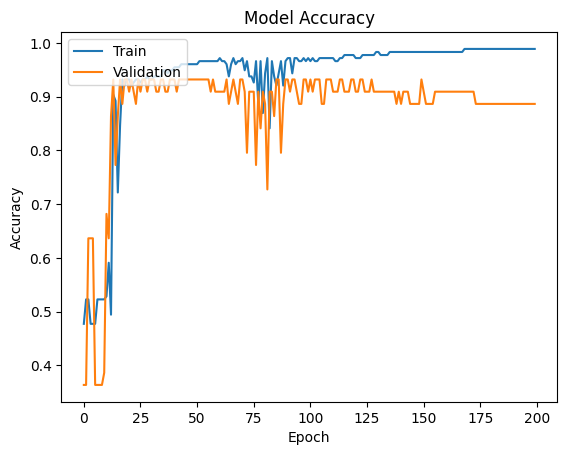

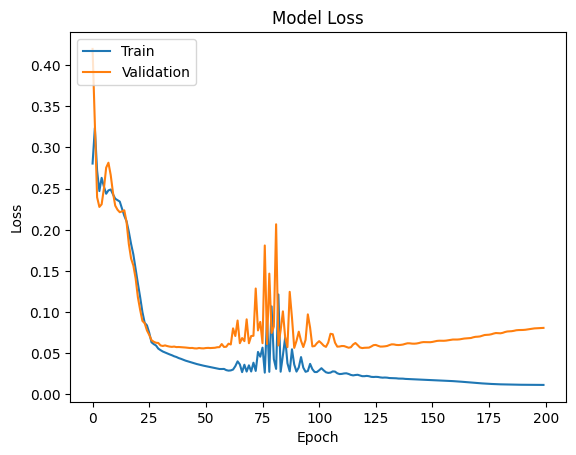

In [149]:
# Plot and save the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('destination_path_accuracy.eps', format='eps', dpi=1000)
plt.show()

# Plot and save the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('destination_path_loss.eps', format='eps', dpi=1000)
plt.show()
